In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5, 7"

In [3]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [45]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)

x = layers.Flatten()(x)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = layers.Dense(train_y.shape[1])(x)

model_cnn = Model(model_input, x)
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 72, 28)]          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 72, 256)           14592     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 72, 128)           65664     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 72, 64)            16448     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 72, 32)            4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                2212

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.05684, saving model to saved_model/cnn_shift_s24_k24_4layer_no_sc.h5
151/151 - 3s - loss: 0.0716 - mae: 0.1037 - val_loss: 0.0515 - val_mae: 0.0568
Epoch 2/6000

Epoch 00002: val_mae improved from 0.05684 to 0.04862, saving model to saved_model/cnn_shift_s24_k24_4layer_no_sc.h5
151/151 - 2s - loss: 0.0442 - mae: 0.0314 - val_loss: 0.0424 - val_mae: 0.0486
Epoch 3/6000

Epoch 00003: val_mae improved from 0.04862 to 0.04482, saving model to saved_model/cnn_shift_s24_k24_4layer_no_sc.h5
151/151 - 2s - loss: 0.0366 - mae: 0.0276 - val_loss: 0.0351 - val_mae: 0.0448
Epoch 4/6000

Epoch 00004: val_mae improved from 0.04482 to 0.04202, saving model to saved_model/cnn_shift_s24_k24_4layer_no_sc.h5
151/151 - 2s - loss: 0.0301 - mae: 0.0247 - val_loss: 0.0290 - val_mae: 0.0420
Epoch 5/6000

Epoch 00005: val_mae improved from 0.04202 to 0.03864, saving model to saved_model/cnn_shift_s24_k24_4layer_no_sc.h5
151/151 - 2s - loss: 0.0247 - mae

Epoch 48/6000

Epoch 00048: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.7174e-04 - mae: 0.0105 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 49/6000

Epoch 00049: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.5463e-04 - mae: 0.0105 - val_loss: 0.0014 - val_mae: 0.0264
Epoch 50/6000

Epoch 00050: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.3916e-04 - mae: 0.0105 - val_loss: 0.0014 - val_mae: 0.0273
Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.2505e-04 - mae: 0.0104 - val_loss: 0.0014 - val_mae: 0.0267
Epoch 52/6000

Epoch 00052: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.1340e-04 - mae: 0.0104 - val_loss: 0.0014 - val_mae: 0.0266
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.02618
151/151 - 2s - loss: 6.0296e-04 - mae: 0.0104 - val_loss: 0.0014 - val_mae: 0.0268
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.02618
151/151 - 2s - loss: 5.9338e-04 - mae: 0.0104 -

Epoch 103/6000

Epoch 00103: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5906e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 104/6000

Epoch 00104: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5803e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 105/6000

Epoch 00105: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5685e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5577e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5464e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5359e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.02610
151/151 - 2s - loss: 4.5249e-04 - mae: 0

Epoch 158/6000

Epoch 00158: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1675e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 159/6000

Epoch 00159: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1627e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 160/6000

Epoch 00160: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1551e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 161/6000

Epoch 00161: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1486e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 162/6000

Epoch 00162: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1410e-04 - mae: 0.0096 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1369e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 164/6000

Epoch 00164: val_mae did not improve from 0.02609
151/151 - 2s - loss: 4.1258e-04 - mae: 0

Epoch 213/6000

Epoch 00213: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8970e-04 - mae: 0.0095 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 214/6000

Epoch 00214: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8939e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 215/6000

Epoch 00215: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8908e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 216/6000

Epoch 00216: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8866e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 217/6000

Epoch 00217: val_mae did not improve from 0.02606
151/151 - 3s - loss: 3.8840e-04 - mae: 0.0095 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 218/6000

Epoch 00218: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8803e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 219/6000

Epoch 00219: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.8765e-04 - mae: 0

Epoch 268/6000

Epoch 00268: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6895e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 269/6000

Epoch 00269: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6853e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 270/6000

Epoch 00270: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6819e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 271/6000

Epoch 00271: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6793e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 272/6000

Epoch 00272: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6770e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 273/6000

Epoch 00273: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.6748e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 274/6000

Epoch 00274: val_mae did not improve from 0.02606
151/151 - 3s - loss: 3.6707e-04 - mae: 0

Epoch 323/6000

Epoch 00323: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5888e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 324/6000

Epoch 00324: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5875e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 325/6000

Epoch 00325: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5864e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 326/6000

Epoch 00326: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5855e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 327/6000

Epoch 00327: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5855e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 328/6000

Epoch 00328: val_mae did not improve from 0.02606
151/151 - 3s - loss: 3.5834e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 329/6000

Epoch 00329: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5843e-04 - mae: 0

Epoch 378/6000

Epoch 00378: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5410e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 379/6000

Epoch 00379: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5399e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 380/6000

Epoch 00380: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5381e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 381/6000

Epoch 00381: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5384e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 382/6000

Epoch 00382: val_mae did not improve from 0.02606
151/151 - 3s - loss: 3.5371e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 383/6000

Epoch 00383: val_mae did not improve from 0.02606
151/151 - 2s - loss: 3.5358e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 384/6000

Epoch 00384: val_mae did not improve from 0.02606
151/151 - 3s - loss: 3.5362e-04 - mae: 0

Epoch 433/6000

Epoch 00433: val_mae did not improve from 0.02595
151/151 - 3s - loss: 3.4903e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 434/6000

Epoch 00434: val_mae did not improve from 0.02595
151/151 - 2s - loss: 3.4891e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 435/6000

Epoch 00435: val_mae did not improve from 0.02595
151/151 - 2s - loss: 3.4897e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 436/6000

Epoch 00436: val_mae did not improve from 0.02595
151/151 - 3s - loss: 3.4883e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 437/6000

Epoch 00437: val_mae did not improve from 0.02595
151/151 - 3s - loss: 3.4874e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 438/6000

Epoch 00438: val_mae did not improve from 0.02595
151/151 - 3s - loss: 3.4869e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 439/6000

Epoch 00439: val_mae did not improve from 0.02595
151/151 - 2s - loss: 3.4864e-04 - mae: 0

Epoch 488/6000

Epoch 00488: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.4446e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 489/6000

Epoch 00489: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.4461e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 490/6000

Epoch 00490: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.4430e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 491/6000

Epoch 00491: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.4428e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 492/6000

Epoch 00492: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.4422e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 493/6000

Epoch 00493: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.4414e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 494/6000

Epoch 00494: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.4399e-04 - mae: 0

Epoch 543/6000

Epoch 00543: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3937e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 544/6000

Epoch 00544: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3920e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 545/6000

Epoch 00545: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3909e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 546/6000

Epoch 00546: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3896e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 547/6000

Epoch 00547: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3888e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 548/6000

Epoch 00548: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3869e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 549/6000

Epoch 00549: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3853e-04 - mae: 0

Epoch 598/6000

Epoch 00598: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3079e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 599/6000

Epoch 00599: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.3074e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 600/6000

Epoch 00600: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.3065e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 601/6000

Epoch 00601: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3073e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 602/6000

Epoch 00602: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.3084e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 603/6000

Epoch 00603: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.3064e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 604/6000

Epoch 00604: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.3057e-04 - mae: 0

Epoch 653/6000

Epoch 00653: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2905e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 654/6000

Epoch 00654: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.2919e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 655/6000

Epoch 00655: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2900e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 656/6000

Epoch 00656: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2901e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 657/6000

Epoch 00657: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2898e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 658/6000

Epoch 00658: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.2906e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 659/6000

Epoch 00659: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2893e-04 - mae: 0

Epoch 708/6000

Epoch 00708: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2761e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 709/6000

Epoch 00709: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2764e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 710/6000

Epoch 00710: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2773e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 711/6000

Epoch 00711: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2760e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 712/6000

Epoch 00712: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.2752e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 713/6000

Epoch 00713: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2753e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 714/6000

Epoch 00714: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2757e-04 - mae: 0

Epoch 763/6000

Epoch 00763: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2638e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 764/6000

Epoch 00764: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2643e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 765/6000

Epoch 00765: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2640e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 766/6000

Epoch 00766: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2630e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 767/6000

Epoch 00767: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2629e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 768/6000

Epoch 00768: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2622e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 769/6000

Epoch 00769: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2637e-04 - mae: 0

Epoch 818/6000

Epoch 00818: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2519e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 819/6000

Epoch 00819: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2518e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 820/6000

Epoch 00820: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2509e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 821/6000

Epoch 00821: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2518e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 822/6000

Epoch 00822: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2517e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 823/6000

Epoch 00823: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2510e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 824/6000

Epoch 00824: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2508e-04 - mae: 0

Epoch 873/6000

Epoch 00873: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2425e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 874/6000

Epoch 00874: val_mae did not improve from 0.02585
151/151 - 3s - loss: 3.2412e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 875/6000

Epoch 00875: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2403e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 876/6000

Epoch 00876: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2405e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 877/6000

Epoch 00877: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2400e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 878/6000

Epoch 00878: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2409e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 879/6000

Epoch 00879: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2404e-04 - mae: 0

Epoch 928/6000

Epoch 00928: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2310e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 929/6000

Epoch 00929: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2316e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 930/6000

Epoch 00930: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2315e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 931/6000

Epoch 00931: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2310e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 932/6000

Epoch 00932: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2317e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 933/6000

Epoch 00933: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2309e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 934/6000

Epoch 00934: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2329e-04 - mae: 0

Epoch 983/6000

Epoch 00983: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2223e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 984/6000

Epoch 00984: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2220e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 985/6000

Epoch 00985: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2210e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 986/6000

Epoch 00986: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2238e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 987/6000

Epoch 00987: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2212e-04 - mae: 0.0090 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 988/6000

Epoch 00988: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2214e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 989/6000

Epoch 00989: val_mae did not improve from 0.02585
151/151 - 2s - loss: 3.2210e-04 - mae: 0

Epoch 1037/6000

Epoch 01037: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2132e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1038/6000

Epoch 01038: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2133e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1039/6000

Epoch 01039: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2125e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1040/6000

Epoch 01040: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2128e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1041/6000

Epoch 01041: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2126e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1042/6000

Epoch 01042: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2119e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1043/6000

Epoch 01043: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2119e-04 -

Epoch 1092/6000

Epoch 01092: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2038e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1093/6000

Epoch 01093: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2042e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1094/6000

Epoch 01094: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2049e-04 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1095/6000

Epoch 01095: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2040e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1096/6000

Epoch 01096: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2030e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1097/6000

Epoch 01097: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2037e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1098/6000

Epoch 01098: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.2040e-04 -

Epoch 1147/6000

Epoch 01147: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1967e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1148/6000

Epoch 01148: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1966e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1149/6000

Epoch 01149: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1955e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1150/6000

Epoch 01150: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1962e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1151/6000

Epoch 01151: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1961e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1152/6000

Epoch 01152: val_mae did not improve from 0.02578
151/151 - 3s - loss: 3.1962e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1153/6000

Epoch 01153: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1959e-04 -

Epoch 1202/6000

Epoch 01202: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1888e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1203/6000

Epoch 01203: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1895e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1204/6000

Epoch 01204: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1882e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1879e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1206/6000

Epoch 01206: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1884e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1207/6000

Epoch 01207: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1883e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1208/6000

Epoch 01208: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1887e-04 -

Epoch 1257/6000

Epoch 01257: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1811e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1258/6000

Epoch 01258: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1810e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1259/6000

Epoch 01259: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1815e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1260/6000

Epoch 01260: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1818e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1261/6000

Epoch 01261: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1798e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1807e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1263/6000

Epoch 01263: val_mae did not improve from 0.02578
151/151 - 2s - loss: 3.1801e-04 -

Epoch 1312/6000

Epoch 01312: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1745e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1313/6000

Epoch 01313: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1743e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1314/6000

Epoch 01314: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1737e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1315/6000

Epoch 01315: val_mae did not improve from 0.02576
151/151 - 3s - loss: 3.1739e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1316/6000

Epoch 01316: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1733e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1317/6000

Epoch 01317: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1739e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1318/6000

Epoch 01318: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1738e-04 -

Epoch 1367/6000

Epoch 01367: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1677e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1368/6000

Epoch 01368: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1683e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1369/6000

Epoch 01369: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1676e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1370/6000

Epoch 01370: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1673e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1371/6000

Epoch 01371: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1670e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1664e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1697e-04 -

Epoch 1422/6000

Epoch 01422: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1608e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1423/6000

Epoch 01423: val_mae did not improve from 0.02576
151/151 - 3s - loss: 3.1605e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1424/6000

Epoch 01424: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1608e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1425/6000

Epoch 01425: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1613e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1426/6000

Epoch 01426: val_mae did not improve from 0.02576
151/151 - 3s - loss: 3.1608e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1427/6000

Epoch 01427: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1604e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1605e-04 -

Epoch 1477/6000

Epoch 01477: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1549e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1478/6000

Epoch 01478: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1544e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1479/6000

Epoch 01479: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1542e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1480/6000

Epoch 01480: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1550e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1481/6000

Epoch 01481: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1538e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1482/6000

Epoch 01482: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1537e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1483/6000

Epoch 01483: val_mae did not improve from 0.02576
151/151 - 2s - loss: 3.1539e-04 -

Epoch 1532/6000

Epoch 01532: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1479e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1533/6000

Epoch 01533: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1473e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1534/6000

Epoch 01534: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1491e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1535/6000

Epoch 01535: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1482e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1536/6000

Epoch 01536: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1481e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1537/6000

Epoch 01537: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1477e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1538/6000

Epoch 01538: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1475e-04 -

Epoch 1587/6000

Epoch 01587: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1432e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1588/6000

Epoch 01588: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1427e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1589/6000

Epoch 01589: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1418e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1590/6000

Epoch 01590: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1422e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1591/6000

Epoch 01591: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1414e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1592/6000

Epoch 01592: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1414e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1593/6000

Epoch 01593: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1410e-04 -

Epoch 1642/6000

Epoch 01642: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1373e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1643/6000

Epoch 01643: val_mae did not improve from 0.02576
151/151 - 3s - loss: 3.1358e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1644/6000

Epoch 01644: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1371e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1645/6000

Epoch 01645: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1358e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1646/6000

Epoch 01646: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1360e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1647/6000

Epoch 01647: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1363e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1648/6000

Epoch 01648: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1350e-04 -

Epoch 1697/6000

Epoch 01697: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1309e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1698/6000

Epoch 01698: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1303e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1699/6000

Epoch 01699: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1302e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 1700/6000

Epoch 01700: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1308e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1701/6000

Epoch 01701: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1297e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1702/6000

Epoch 01702: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1308e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1703/6000

Epoch 01703: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1305e-04 -

Epoch 1752/6000

Epoch 01752: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1250e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1753/6000

Epoch 01753: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1258e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1754/6000

Epoch 01754: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1237e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1755/6000

Epoch 01755: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1243e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1756/6000

Epoch 01756: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1241e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1757/6000

Epoch 01757: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1245e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1758/6000

Epoch 01758: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1245e-04 -

Epoch 1807/6000

Epoch 01807: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1191e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1808/6000

Epoch 01808: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1189e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1809/6000

Epoch 01809: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1194e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1810/6000

Epoch 01810: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1195e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1811/6000

Epoch 01811: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1188e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1812/6000

Epoch 01812: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1190e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1813/6000

Epoch 01813: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1180e-04 -

Epoch 1862/6000

Epoch 01862: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1140e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1863/6000

Epoch 01863: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1135e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1864/6000

Epoch 01864: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1134e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1865/6000

Epoch 01865: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1136e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1866/6000

Epoch 01866: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1149e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 1867/6000

Epoch 01867: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1141e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1868/6000

Epoch 01868: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1134e-04 -

Epoch 1917/6000

Epoch 01917: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1088e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1918/6000

Epoch 01918: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1081e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 1919/6000

Epoch 01919: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1085e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1920/6000

Epoch 01920: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1076e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1921/6000

Epoch 01921: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1080e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1922/6000

Epoch 01922: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1080e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1923/6000

Epoch 01923: val_mae did not improve from 0.02576
151/151 - 4s - loss: 3.1085e-04 -

Epoch 1972/6000

Epoch 01972: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1028e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1973/6000

Epoch 01973: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1028e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1974/6000

Epoch 01974: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1042e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 1975/6000

Epoch 01975: val_mae did not improve from 0.02575
151/151 - 3s - loss: 3.1028e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1976/6000

Epoch 01976: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1026e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1977/6000

Epoch 01977: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1028e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1978/6000

Epoch 01978: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.1029e-04 -

Epoch 2027/6000

Epoch 02027: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0975e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2028/6000

Epoch 02028: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0972e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2029/6000

Epoch 02029: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0978e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2030/6000

Epoch 02030: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0981e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2031/6000

Epoch 02031: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0971e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2032/6000

Epoch 02032: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0975e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2033/6000

Epoch 02033: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0974e-04 -

Epoch 2082/6000

Epoch 02082: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0931e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2083/6000

Epoch 02083: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0929e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2084/6000

Epoch 02084: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0929e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2085/6000

Epoch 02085: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0925e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2086/6000

Epoch 02086: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0945e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2087/6000

Epoch 02087: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0917e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2088/6000

Epoch 02088: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0923e-04 -

Epoch 2137/6000

Epoch 02137: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0883e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2138/6000

Epoch 02138: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0880e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2139/6000

Epoch 02139: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0882e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2140/6000

Epoch 02140: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0877e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2141/6000

Epoch 02141: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0877e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2142/6000

Epoch 02142: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0886e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2143/6000

Epoch 02143: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0879e-04 -

Epoch 2192/6000

Epoch 02192: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0842e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2193/6000

Epoch 02193: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0843e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2194/6000

Epoch 02194: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0832e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2195/6000

Epoch 02195: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0827e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2196/6000

Epoch 02196: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0835e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2197/6000

Epoch 02197: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0823e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2198/6000

Epoch 02198: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0826e-04 -

Epoch 2247/6000

Epoch 02247: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0785e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2248/6000

Epoch 02248: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0790e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2249/6000

Epoch 02249: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0787e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2250/6000

Epoch 02250: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0784e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2251/6000

Epoch 02251: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0778e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2252/6000

Epoch 02252: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0787e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2253/6000

Epoch 02253: val_mae did not improve from 0.02575
151/151 - 4s - loss: 3.0780e-04 -

Epoch 2302/6000

Epoch 02302: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0738e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2303/6000

Epoch 02303: val_mae did not improve from 0.02574
151/151 - 3s - loss: 3.0749e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2304/6000

Epoch 02304: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0747e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2305/6000

Epoch 02305: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0752e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2306/6000

Epoch 02306: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0737e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2307/6000

Epoch 02307: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0746e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2308/6000

Epoch 02308: val_mae did not improve from 0.02574
151/151 - 4s - loss: 3.0742e-04 -

Epoch 2357/6000

Epoch 02357: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0696e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2358/6000

Epoch 02358: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0698e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2359/6000

Epoch 02359: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0694e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2360/6000

Epoch 02360: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0711e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2361/6000

Epoch 02361: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0693e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2362/6000

Epoch 02362: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0702e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2363/6000

Epoch 02363: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0696e-04 -

Epoch 2412/6000

Epoch 02412: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0658e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2413/6000

Epoch 02413: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0656e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2414/6000

Epoch 02414: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0650e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2415/6000

Epoch 02415: val_mae did not improve from 0.02569
151/151 - 3s - loss: 3.0660e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2416/6000

Epoch 02416: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0654e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2417/6000

Epoch 02417: val_mae did not improve from 0.02569
151/151 - 3s - loss: 3.0652e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2418/6000

Epoch 02418: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0658e-04 -

Epoch 2467/6000

Epoch 02467: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0618e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2468/6000

Epoch 02468: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0620e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2469/6000

Epoch 02469: val_mae did not improve from 0.02569
151/151 - 3s - loss: 3.0622e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2470/6000

Epoch 02470: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0608e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2471/6000

Epoch 02471: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0611e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2472/6000

Epoch 02472: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0614e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2473/6000

Epoch 02473: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0620e-04 -

Epoch 2522/6000

Epoch 02522: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0584e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2523/6000

Epoch 02523: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0586e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2524/6000

Epoch 02524: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0577e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2525/6000

Epoch 02525: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0575e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2526/6000

Epoch 02526: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0577e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2527/6000

Epoch 02527: val_mae did not improve from 0.02569
151/151 - 4s - loss: 3.0568e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2528/6000

Epoch 02528: val_mae did not improve from 0.02569
151/151 - 3s - loss: 3.0572e-04 -

Epoch 2577/6000

Epoch 02577: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0539e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2578/6000

Epoch 02578: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0530e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2579/6000

Epoch 02579: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0534e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2580/6000

Epoch 02580: val_mae did not improve from 0.02569
151/151 - 3s - loss: 3.0539e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2581/6000

Epoch 02581: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0537e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2582/6000

Epoch 02582: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0538e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2583/6000

Epoch 02583: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0532e-04 -

Epoch 2632/6000

Epoch 02632: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0511e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2633/6000

Epoch 02633: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0506e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2634/6000

Epoch 02634: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0500e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2635/6000

Epoch 02635: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0498e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2636/6000

Epoch 02636: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0494e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2637/6000

Epoch 02637: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0499e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2638/6000

Epoch 02638: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0490e-04 -

Epoch 2687/6000

Epoch 02687: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0464e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2688/6000

Epoch 02688: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0464e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2689/6000

Epoch 02689: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0456e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2690/6000

Epoch 02690: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0463e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2691/6000

Epoch 02691: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0460e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2692/6000

Epoch 02692: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0459e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2693/6000

Epoch 02693: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0468e-04 -

Epoch 2742/6000

Epoch 02742: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0426e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2743/6000

Epoch 02743: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0420e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 2744/6000

Epoch 02744: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0426e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2745/6000

Epoch 02745: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0444e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2746/6000

Epoch 02746: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0420e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2747/6000

Epoch 02747: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0423e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2748/6000

Epoch 02748: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0409e-04 -

Epoch 2797/6000

Epoch 02797: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0390e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2798/6000

Epoch 02798: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0388e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2799/6000

Epoch 02799: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0390e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2800/6000

Epoch 02800: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0376e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2801/6000

Epoch 02801: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0399e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2802/6000

Epoch 02802: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0387e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2803/6000

Epoch 02803: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0382e-04 -

Epoch 2852/6000

Epoch 02852: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0364e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2853/6000

Epoch 02853: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0353e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2854/6000

Epoch 02854: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0360e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2855/6000

Epoch 02855: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0348e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2856/6000

Epoch 02856: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0350e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2857/6000

Epoch 02857: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0352e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2858/6000

Epoch 02858: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0362e-04 -

Epoch 2907/6000

Epoch 02907: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0312e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2908/6000

Epoch 02908: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0318e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2909/6000

Epoch 02909: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0318e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2910/6000

Epoch 02910: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0314e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2911/6000

Epoch 02911: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0331e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2912/6000

Epoch 02912: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0315e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 2913/6000

Epoch 02913: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0320e-04 -

Epoch 2962/6000

Epoch 02962: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0289e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2963/6000

Epoch 02963: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0289e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2964/6000

Epoch 02964: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0279e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2965/6000

Epoch 02965: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0279e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 2966/6000

Epoch 02966: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0286e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2967/6000

Epoch 02967: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0281e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 2968/6000

Epoch 02968: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0274e-04 -

Epoch 3017/6000

Epoch 03017: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0250e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3018/6000

Epoch 03018: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0246e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3019/6000

Epoch 03019: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0249e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3020/6000

Epoch 03020: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0263e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3021/6000

Epoch 03021: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0247e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3022/6000

Epoch 03022: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0245e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3023/6000

Epoch 03023: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0250e-04 -

Epoch 3072/6000

Epoch 03072: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0225e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 3073/6000

Epoch 03073: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0227e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3074/6000

Epoch 03074: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0221e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3075/6000

Epoch 03075: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0215e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3076/6000

Epoch 03076: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0218e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3077/6000

Epoch 03077: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0217e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3078/6000

Epoch 03078: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0220e-04 -

Epoch 3127/6000

Epoch 03127: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0186e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3128/6000

Epoch 03128: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0188e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3129/6000

Epoch 03129: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0182e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0262
Epoch 3130/6000

Epoch 03130: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0178e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3131/6000

Epoch 03131: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0183e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3132/6000

Epoch 03132: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0193e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3133/6000

Epoch 03133: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0183e-04 -

Epoch 3182/6000

Epoch 03182: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0152e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3183/6000

Epoch 03183: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0156e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3184/6000

Epoch 03184: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0149e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3185/6000

Epoch 03185: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0146e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0262
Epoch 3186/6000

Epoch 03186: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0150e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3187/6000

Epoch 03187: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0168e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3188/6000

Epoch 03188: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0151e-04 -

Epoch 3237/6000

Epoch 03237: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0120e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3238/6000

Epoch 03238: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0121e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3239/6000

Epoch 03239: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0121e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3240/6000

Epoch 03240: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0121e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3241/6000

Epoch 03241: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0123e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3242/6000

Epoch 03242: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0123e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3243/6000

Epoch 03243: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0137e-04 -

Epoch 3292/6000

Epoch 03292: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0091e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3293/6000

Epoch 03293: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0091e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3294/6000

Epoch 03294: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0098e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3295/6000

Epoch 03295: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0092e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3296/6000

Epoch 03296: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0096e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3297/6000

Epoch 03297: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0096e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3298/6000

Epoch 03298: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0098e-04 -

Epoch 3347/6000

Epoch 03347: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0063e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3348/6000

Epoch 03348: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0063e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3349/6000

Epoch 03349: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0068e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3350/6000

Epoch 03350: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0067e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3351/6000

Epoch 03351: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0061e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3352/6000

Epoch 03352: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0060e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3353/6000

Epoch 03353: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0062e-04 -

Epoch 3402/6000

Epoch 03402: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0037e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3403/6000

Epoch 03403: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0041e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3404/6000

Epoch 03404: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0037e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3405/6000

Epoch 03405: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0043e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3406/6000

Epoch 03406: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0044e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3407/6000

Epoch 03407: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0033e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3408/6000

Epoch 03408: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0033e-04 -

Epoch 3457/6000

Epoch 03457: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0008e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3458/6000

Epoch 03458: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0010e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3459/6000

Epoch 03459: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0008e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3460/6000

Epoch 03460: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0003e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3461/6000

Epoch 03461: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0001e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3462/6000

Epoch 03462: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0012e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3463/6000

Epoch 03463: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0003e-04 -

Epoch 3512/6000

Epoch 03512: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9982e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3513/6000

Epoch 03513: val_mae did not improve from 0.02569
151/151 - 2s - loss: 3.0000e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3514/6000

Epoch 03514: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9989e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3515/6000

Epoch 03515: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9977e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3516/6000

Epoch 03516: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9977e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3517/6000

Epoch 03517: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9978e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 3518/6000

Epoch 03518: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9980e-04 -

Epoch 3567/6000

Epoch 03567: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9957e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3568/6000

Epoch 03568: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9951e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3569/6000

Epoch 03569: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9949e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3570/6000

Epoch 03570: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9966e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3571/6000

Epoch 03571: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9958e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3572/6000

Epoch 03572: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9952e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3573/6000

Epoch 03573: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9957e-04 -

Epoch 3622/6000

Epoch 03622: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9924e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3623/6000

Epoch 03623: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9932e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3624/6000

Epoch 03624: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9932e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3625/6000

Epoch 03625: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9936e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3626/6000

Epoch 03626: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9930e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3627/6000

Epoch 03627: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9923e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3628/6000

Epoch 03628: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9924e-04 -

Epoch 3677/6000

Epoch 03677: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9898e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3678/6000

Epoch 03678: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9901e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3679/6000

Epoch 03679: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9900e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3680/6000

Epoch 03680: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9897e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3681/6000

Epoch 03681: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9896e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3682/6000

Epoch 03682: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9899e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3683/6000

Epoch 03683: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9896e-04 -

Epoch 3732/6000

Epoch 03732: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9872e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3733/6000

Epoch 03733: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9875e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 3734/6000

Epoch 03734: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9875e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 3735/6000

Epoch 03735: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9872e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 3736/6000

Epoch 03736: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9881e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3737/6000

Epoch 03737: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9875e-04 - mae: 0.0088 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 3738/6000

Epoch 03738: val_mae did not improve from 0.02569
151/151 - 2s - loss: 2.9870e-04 -

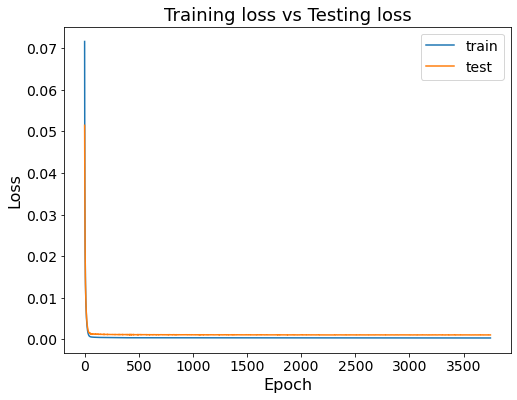

In [47]:
lr = 0.00001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_cnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_shift_s{}_k{}_4layer_no_sc.h5'.format(S, K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [48]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_s{}_k{}_4layer_no_sc.h5'.format(S, K))

In [49]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [50]:
# inv_y

In [51]:
# inv_yhat

In [52]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.1361
RMSE = 0.1637
